In [1]:
#!pip3 install tensorflow
#!pip3 install tensorflow_hub
#!pip3 install tensorflow_addons
#!pip3 install pandarallel
#!pip3 install opencv-python
#!pip3 install scipy
#!pip3 install kaggle
!pip3 install modules

  Preparing metadata (setup.py) ... done
  Created wheel for modules: filename=modules-1.0.0-py3-none-any.whl size=1222 sha256=718d7b0dc9db7c8de0b2e09f6aaabb686f43ceee0e30e9da45dac56ae7e7577a
  Stored in directory: /root/.cache/pip/wheels/05/fb/b9/38f6beca84a9886bbad5f607ec36b7ab8eca58b4df2b4d1cf3
Successfully built modules


In [2]:
#Importing Relevant Packages
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_addons as tfa
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from pandarallel import pandarallel
from sklearn.model_selection import GroupKFold, StratifiedKFold
from scipy.spatial import cKDTree

In [3]:
from collections import Counter
from datetime import datetime
from glob import glob
import modules
import warnings
import requests
import hashlib
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

In [4]:
#Importing packages for Visualization
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

		– MATPLOTLIB VERSION: 3.5.3
Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



In [5]:
#import cv2
#import glob

DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

#all_train_images = [cv2.imread(file) for file in glob.glob('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png')]

#print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")

In [6]:
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
all_train_images[:5]

['/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0082_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0113_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0076_266_266_1.50_1.50.png',
 '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0125_266_266_1.50_1.50.png']

In [7]:
SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")
ss_df = pd.read_csv(SS_CSV)

SF2LF = {"lb":"Large Bowel","sb":"Small Bowel","st":"Stomach"}
LF2SF = {v:k for k,v in SF2LF.items()}

In [8]:
def get_filepath_from_partial_identifier(_ident, file_list):
    return [x for x in file_list if _ident in x][0]

def df_preprocessing(df, globbed_file_list, is_test=False):
    """ The preprocessing steps applied to get column information """
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_ident"] = (globbed_file_list[0].rsplit("/", 4)[0]+"/"+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                           df["case_id_str"]+"/"+ # .../case###/
                           df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                           "/scans/"+df["slice_id"]) # .../slice_#### 
    _tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in globbed_file_list], "f_path":globbed_file_list})
    df = df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

    if not is_test:
        # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
        l_bowel_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
        s_bowel_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
        stomach_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
        df = df.merge(l_bowel_df, on="id", how="left")
        df = df.merge(s_bowel_df, on="id", how="left")
        df = df.merge(stomach_df, on="id", how="left")
        df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
        df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
        df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
        new_col_order = ["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id",]
    if is_test: new_col_order.insert(1, "class")
    new_col_order = [_c for _c in new_col_order if _c in df.columns]
    df = df[new_col_order]


    return df

In [9]:
print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...\n\n")

# 1. Get Case-ID as a column (str and int)
train_df["case_id_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[0])
train_df["case_id"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

# 2. Get Day as a column
train_df["day_num_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[1])
train_df["day_num"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

# 3. Get Slice Identifier as a column
train_df["slice_id"] = train_df["id"].apply(lambda x: x.split("_", 2)[2])

# 4. Get full file paths for the representative scans
train_df["_partial_ident"] = (TRAIN_DIR+"/"+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                             train_df["case_id_str"]+"/"+ # .../case###/
                             train_df["case_id_str"]+"_"+train_df["day_num_str"]+  # .../case###_day##/
                             "/scans/"+train_df["slice_id"]) # .../slice_#### 
_tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in all_train_images], "f_path":all_train_images})
train_df = train_df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

# Minor cleanup of our temporary workaround
del _tmp_merge_df; gc.collect(); gc.collect()

# 5. Get slice dimensions from filepath (int in pixels)
train_df["slice_h"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
train_df["slice_w"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

# 6. Pixel spacing from filepath (float in mm)
train_df["px_spacing_h"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
train_df["px_spacing_w"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

# 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
l_bowel_train_df = train_df[train_df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
s_bowel_train_df = train_df[train_df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
stomach_train_df = train_df[train_df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
train_df = train_df.merge(l_bowel_train_df, on="id", how="left")
train_df = train_df.merge(s_bowel_train_df, on="id", how="left")
train_df = train_df.merge(stomach_train_df, on="id", how="left")
train_df = train_df.drop_duplicates(subset=["id",]).reset_index(drop=True)
train_df["lb_seg_flag"] = train_df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["sb_seg_flag"] = train_df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["st_seg_flag"] = train_df["st_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["n_segs"] = train_df["lb_seg_flag"].astype(int)+train_df["sb_seg_flag"].astype(int)+train_df["st_seg_flag"].astype(int)

# 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
train_df = train_df[["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id",]]
# 9. Display update dataframe
print("\n... UPDATED TRAINING DATAFRAME... \n")
display(train_df)

#ss_df = df_preprocessing(ss_df, all_test_images, is_test=True)
#print("\n\n\n... UPDATED SUBMISSION DATAFRAME... \n")
#display(ss_df)

print("\n... UPDATING DATAFRAME WITH ACCESSIBLE INFORMATION FINISHED ...\n\n")


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...



... UPDATED TRAINING DATAFRAME... 



,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
0,case123_day20_slice_0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0001
1,case123_day20_slice_0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0002
2,case123_day20_slice_0003,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0003
3,case123_day20_slice_0004,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0004
4,case123_day20_slice_0005,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0140
38492,case30_day0_slice_0141,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0141
38493,case30_day0_slice_0142,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0142
38494,case30_day0_slice_0143,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0143



... UPDATING DATAFRAME WITH ACCESSIBLE INFORMATION FINISHED ...




In [10]:
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)


In [11]:
def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
    

In [12]:
def get_overlay(img_path, rle_strs, img_shape, _alpha=0.999, _beta=0.35, _gamma=0):
    _img = open_gray16(img_path, to_rgb=True)
    _img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
    _seg_rgb = np.stack([rle_decode(rle_str, shape=img_shape, color=1) if rle_str is not None else np.zeros(img_shape, dtype=np.float32) for rle_str in rle_strs], axis=-1).astype(np.float32)
    seg_overlay = cv2.addWeighted(src1=_img, alpha=_alpha, 
                                  src2=_seg_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def examine_id(ex_id, df=train_df, plot_overlay=True, print_meta=False, plot_grayscale=False, plot_binary_segmentation=False):
    """ Wrapper function to allow for easy visual exploration of an example """
    print(f"\n... ID ({ex_id}) EXPLORATION STARTED ...\n\n")
    demo_ex = df[df.id==ex_id].squeeze()

    if print_meta:
        print(f"\n... WITH DEMO_ID=`{DEMO_ID}` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... \n\n")
        display(demo_ex.to_frame())

    if plot_grayscale:
        print(f"\n\n... GRAYSCALE IMAGE PLOT ...\n")
        plt.figure(figsize=(12,12))
        plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
        plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
        plt.axis(False)
        plt.show()

    if plot_binary_segmentation:
        print(f"\n\n... BINARY SEGMENTATION MASKS ...\n")
        plt.figure(figsize=(20,10))
        for i, _seg_type in enumerate(["lb", "sb", "st"]):
            if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
            plt.subplot(1,3,i+1)
            plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
            plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
            plt.axis(False)
        plt.tight_layout()
        plt.show()

    if plot_overlay:
        print(f"\n\n... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...\n")
        # We need to normalize the loaded image values to be between 0 and 1 or else our plot will look weird
        # _img = open_gray16(demo_ex.f_path, to_rgb=True)
        #_img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
        #_seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1) if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else np.zeros((demo_ex.slice_w, demo_ex.slice_h)) for _seg_type in ["lb", "sb", "st"]], axis=-1).astype(np.float32)
        #seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, 
                                      #src2=_seg_rgb, beta=0.33, gamma=0)
        _rle_strs = [demo_ex[f"{_seg_type}_seg_rle"] if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else None for _seg_type in ["lb", "sb", "st"]]
        seg_overlay = get_overlay(demo_ex.f_path, _rle_strs, img_shape=(demo_ex.slice_w, demo_ex.slice_h))

        plt.figure(figsize=(12,12))
        plt.imshow(seg_overlay)
        plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
        plt.legend(handles,labels)
        plt.axis(False)
        plt.show()

    print("\n\n... SINGLE ID EXPLORATION FINISHED ...\n\n")
            

In [13]:
## To find the case scan which contains lb, sb and stomach segmentation

train_mask = (train_df['lb_seg_flag'] == True) & (train_df['sb_seg_flag'] == True) & (train_df['st_seg_flag'] == True) & (train_df['case_id_str'] == 'case108')
train_df[train_mask][-8:]

,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
24641,case108_day13_slice_0082,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17959 9 18223 17 18244 3 18488 27 18754 33 190...,True,21978 20 22242 24 22506 27 22771 30 23037 31 2...,True,24313 6 24577 12 24841 17 25106 20 25371 22 25...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0082
24642,case108_day13_slice_0083,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17693 4 17957 8 18221 18 18485 24 18749 29 190...,True,21976 12 22240 27 22505 30 22770 33 23035 36 2...,True,24578 9 24841 14 25105 18 25370 20 25635 22 25...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0083
24643,case108_day13_slice_0084,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17694 1 17957 7 18221 18 18484 24 18691 4 1874...,True,21715 6 21976 15 21996 5 22240 30 22504 35 227...,True,24844 6 25107 12 25371 16 25635 19 25899 21 26...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0084
24644,case108_day13_slice_0085,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,17960 3 18222 13 18425 3 18483 24 18689 7 1874...,True,21715 11 21730 5 21978 26 22241 32 22505 36 22...,True,25111 2 25374 8 25638 12 25901 16 26165 19 264...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0085
24645,case108_day13_slice_0086,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18224 10 18425 4 18484 21 18689 8 18748 26 189...,True,21465 1 21716 20 21979 26 22244 30 22508 34 22...,True,25641 4 25904 9 26167 13 26431 16 26695 18 269...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0086
24646,case108_day13_slice_0087,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18226 5 18425 4 18486 16 18689 9 18747 23 1895...,True,21465 1 21718 17 21981 23 22245 29 22510 32 22...,True,26172 3 26435 8 26698 12 26962 14 27226 16 274...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0087
24647,case108_day13_slice_0088,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18489 11 18691 8 18741 27 18955 13 19002 34 19...,True,21724 9 21984 17 22248 23 22487 9 22513 28 227...,True,26703 1 26965 7 27229 10 27493 13 27758 14 280...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0088
24648,case108_day13_slice_0089,/kaggle/input/uw-madison-gi-tract-image-segmen...,3,18492 2 18741 25 18956 11 19003 31 19219 17 19...,True,21993 6 22222 7 22252 15 22486 12 22516 23 227...,True,27498 4 27761 9 28025 11 28290 13 28555 14 288...,True,266,266,1.5,1.5,case108,108,day13,13,slice_0089



... SINGLE ID EXPLORATION STARTED ...



... WITH DEMO_ID=`case108_day13_slice_0084` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... 




,24643
id,case108_day13_slice_0084
f_path,/kaggle/input/uw-madison-gi-tract-image-segmen...
n_segs,3
lb_seg_rle,17694 1 17957 7 18221 18 18484 24 18691 4 1874...
lb_seg_flag,True
sb_seg_rle,21715 6 21976 15 21996 5 22240 30 22504 35 227...
sb_seg_flag,True
st_seg_rle,24844 6 25107 12 25371 16 25635 19 25899 21 26...
st_seg_flag,True
slice_h,266




... LET'S PLOT THE IMAGE FIRST ...



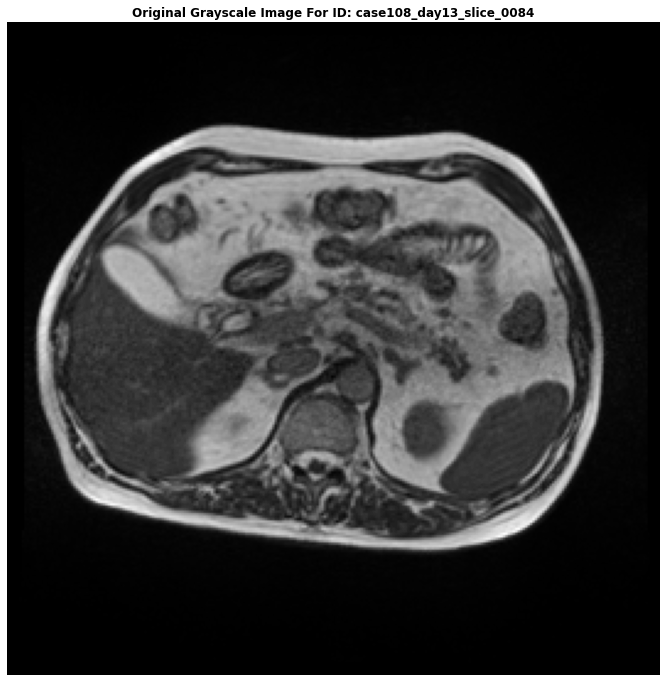



... LET'S PLOT THE 3 SEGMENTATION MASKS ...



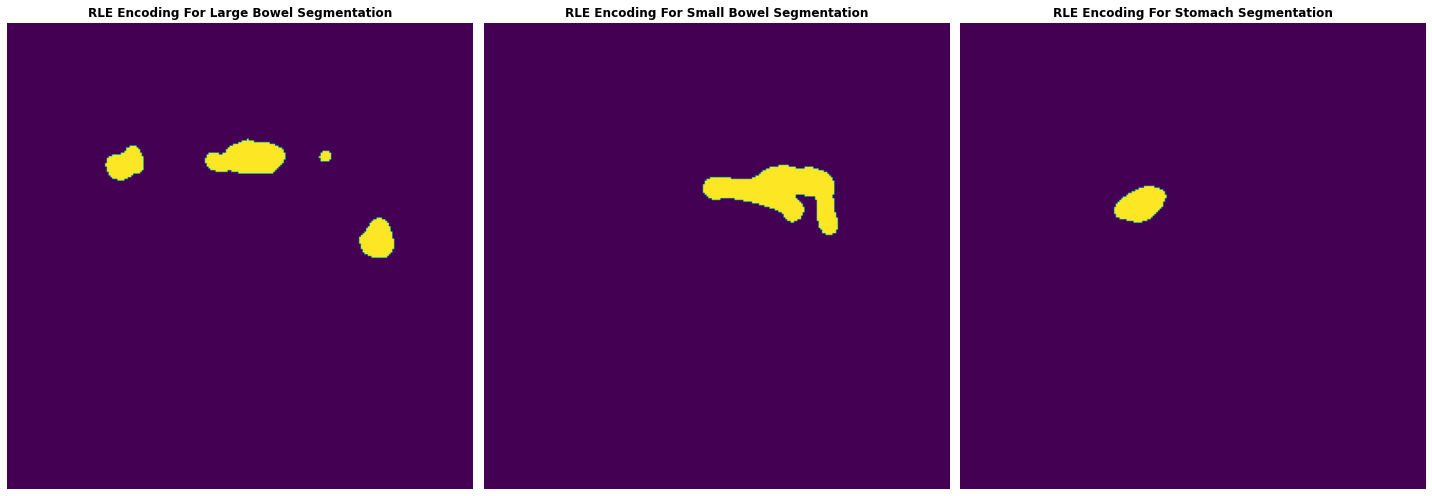



... LET'S PLOT THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...



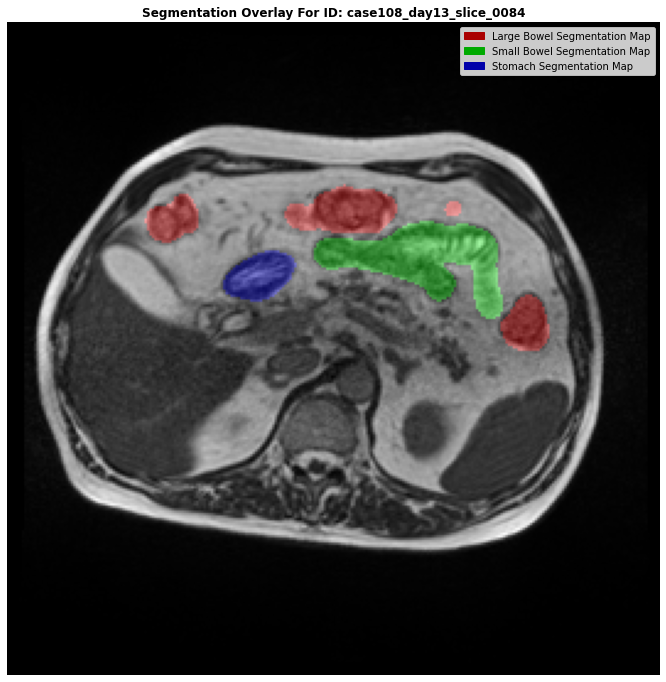



... LET'S PRINT THE RELEVANT INFORMATION ...

	--> IMAGE CASE ID              : 108
	--> IMAGE DAY NUMBER           : 13
	--> IMAGE SLICE WIDTH          : 266
	--> IMAGE SLICE HEIGHT         : 266
	--> IMAGE PIXEL SPACING WIDTH  : 1.5
	--> IMAGE PIXEL SPACING HEIGHT : 1.5


... SINGLE ID EXPLORATION FINISHED ...




In [14]:
print("\n... SINGLE ID EXPLORATION STARTED ...\n\n")

DEMO_ID = "case108_day13_slice_0084"   #Using from above analysis
demo_ex = train_df[train_df.id==DEMO_ID].squeeze()

print(f"\n... WITH DEMO_ID=`{DEMO_ID}` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... \n\n")
display(demo_ex.to_frame())

print(f"\n\n... LET'S PLOT THE IMAGE FIRST ...\n")
plt.figure(figsize=(12,12))
plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
plt.axis(False)
plt.show()

print(f"\n\n... LET'S PLOT THE 3 SEGMENTATION MASKS ...\n")

plt.figure(figsize=(20,10))
for i, _seg_type in enumerate(["lb", "sb", "st"]):
    if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
    plt.subplot(1,3,i+1)
    plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
    plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
    plt.axis(False)
plt.tight_layout()
plt.show()

print(f"\n\n... LET'S PLOT THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...\n")

# We need to normalize the loaded image values to be between 0 and 1 or else our plot will look weird
_img = open_gray16(demo_ex.f_path, to_rgb=True)
_img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
_seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1) if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else np.zeros((demo_ex.slice_w, demo_ex.slice_h)) for _seg_type in ["lb", "sb", "st"]], axis=-1).astype(np.float32)
seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, 
                              src2=_seg_rgb, beta=0.33, gamma=0.0)
plt.figure(figsize=(12,12))
plt.imshow(seg_overlay)
plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
plt.legend(handles,labels)
plt.axis(False)
plt.show()

print(f"\n\n... LET'S PRINT THE RELEVANT INFORMATION ...\n")
print(f"\t--> IMAGE CASE ID              : {demo_ex.case_id}")
print(f"\t--> IMAGE DAY NUMBER           : {demo_ex.day_num}")
print(f"\t--> IMAGE SLICE WIDTH          : {demo_ex.slice_w}")
print(f"\t--> IMAGE SLICE HEIGHT         : {demo_ex.slice_h}")
print(f"\t--> IMAGE PIXEL SPACING WIDTH  : {demo_ex.px_spacing_w}")
print(f"\t--> IMAGE PIXEL SPACING HEIGHT : {demo_ex.px_spacing_h}")

print("\n\n... SINGLE ID EXPLORATION FINISHED ...\n\n")


... ID (case58_day0_slice_0057) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



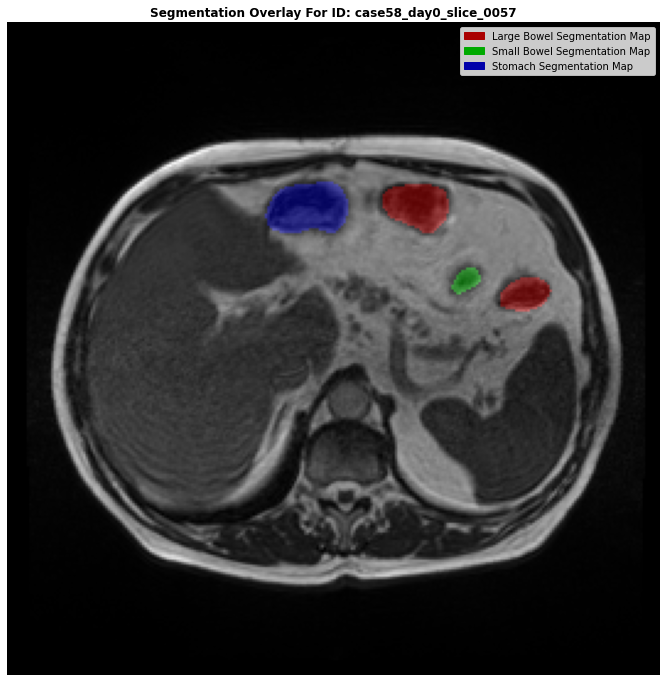



... SINGLE ID EXPLORATION FINISHED ...



... ID (case136_day25_slice_0080) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



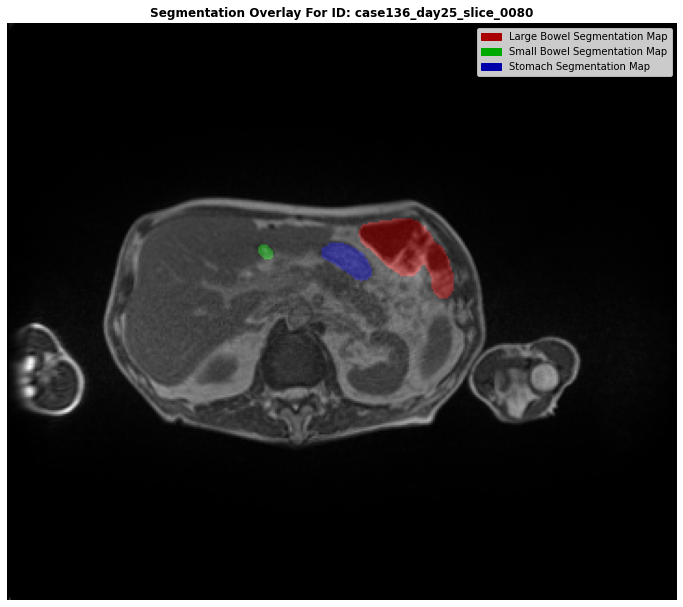



... SINGLE ID EXPLORATION FINISHED ...



... ID (case121_day14_slice_0076) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



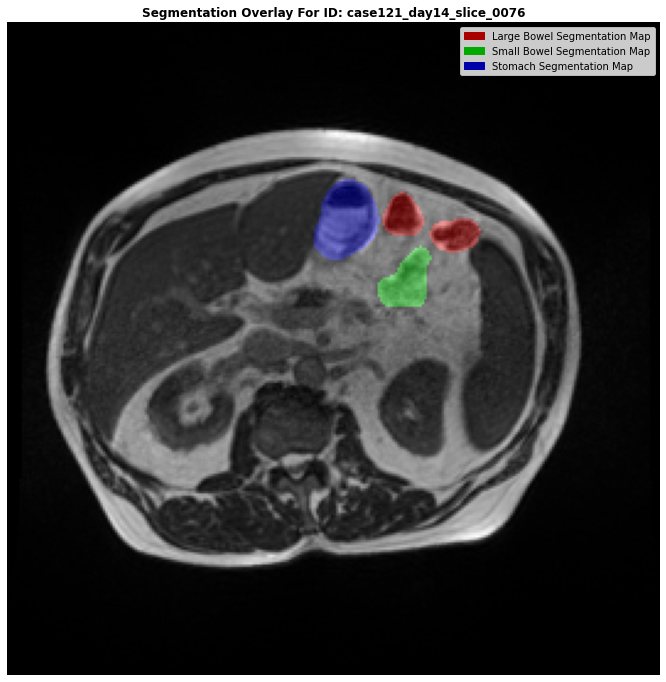



... SINGLE ID EXPLORATION FINISHED ...



... ID (case148_day20_slice_0081) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



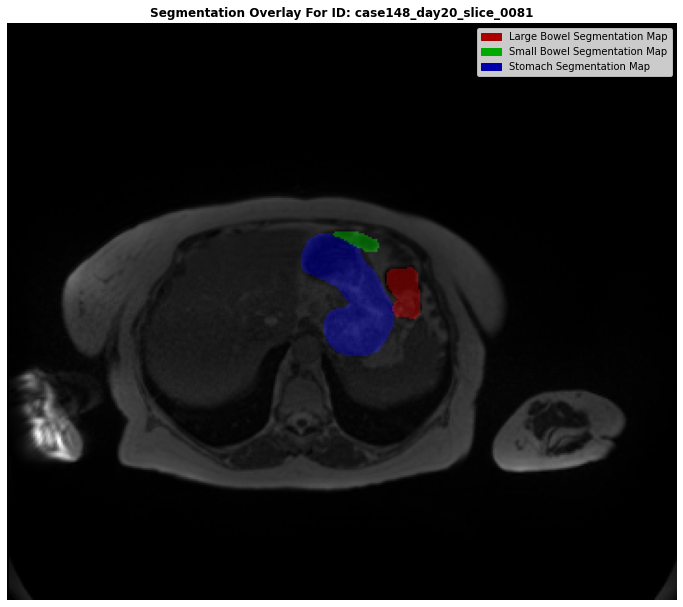



... SINGLE ID EXPLORATION FINISHED ...



... ID (case118_day0_slice_0037) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



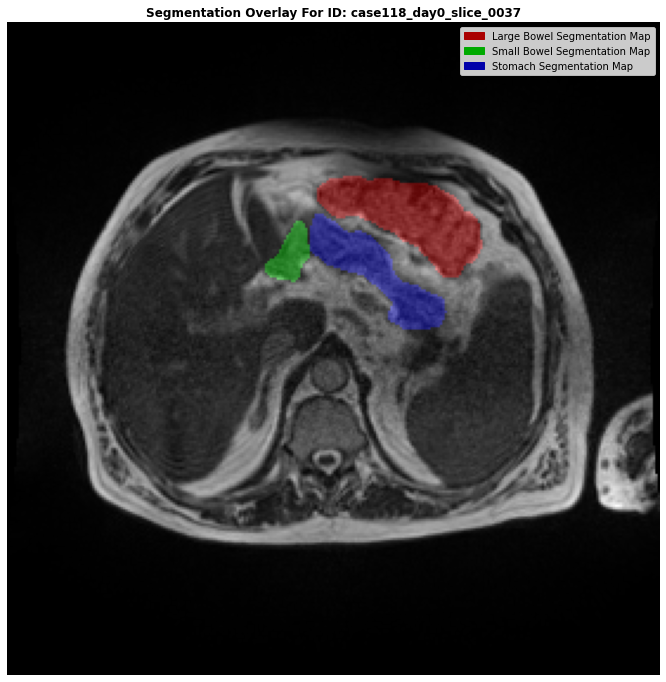



... SINGLE ID EXPLORATION FINISHED ...



... ID (case11_day0_slice_0060) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



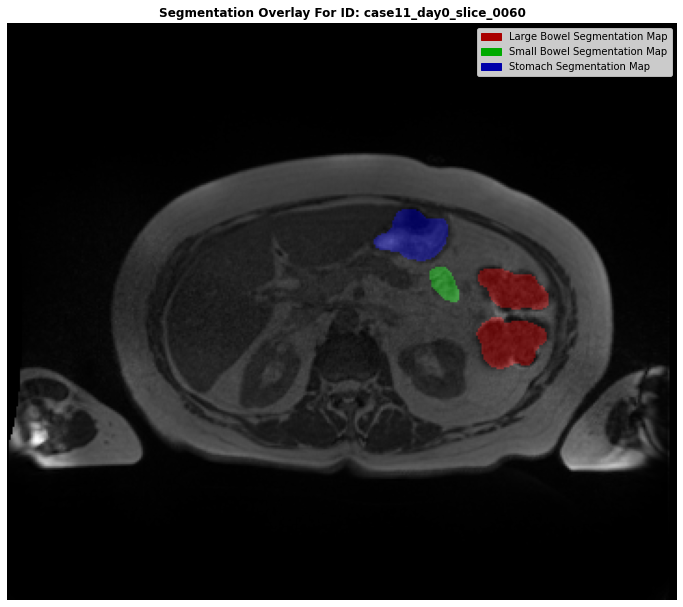



... SINGLE ID EXPLORATION FINISHED ...



... ID (case90_day0_slice_0085) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



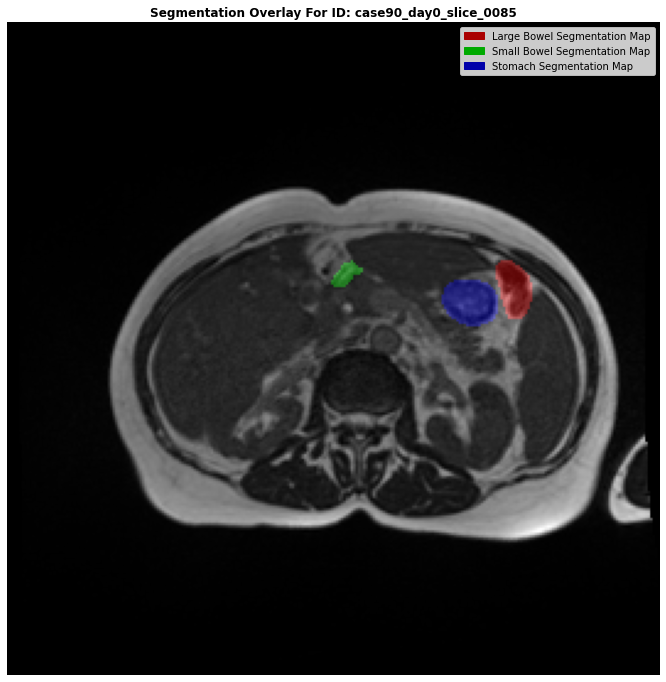



... SINGLE ID EXPLORATION FINISHED ...



... ID (case81_day0_slice_0075) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



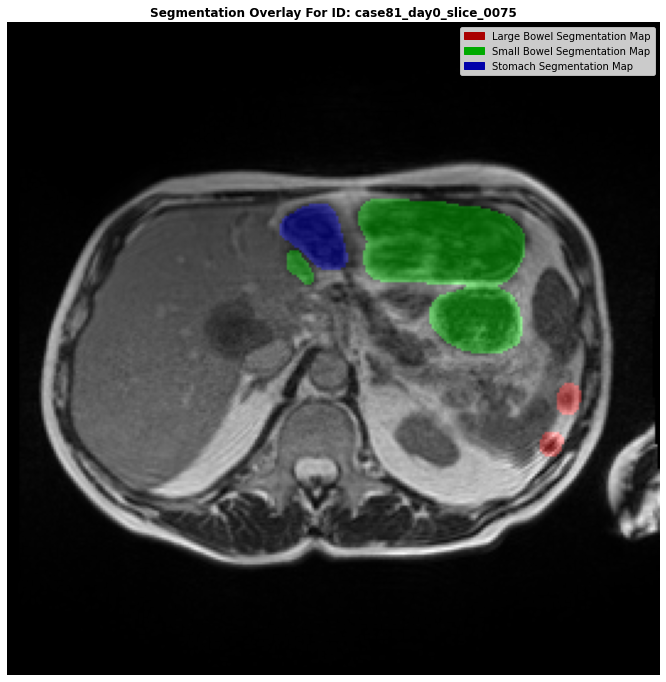



... SINGLE ID EXPLORATION FINISHED ...



... ID (case2_day1_slice_0078) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



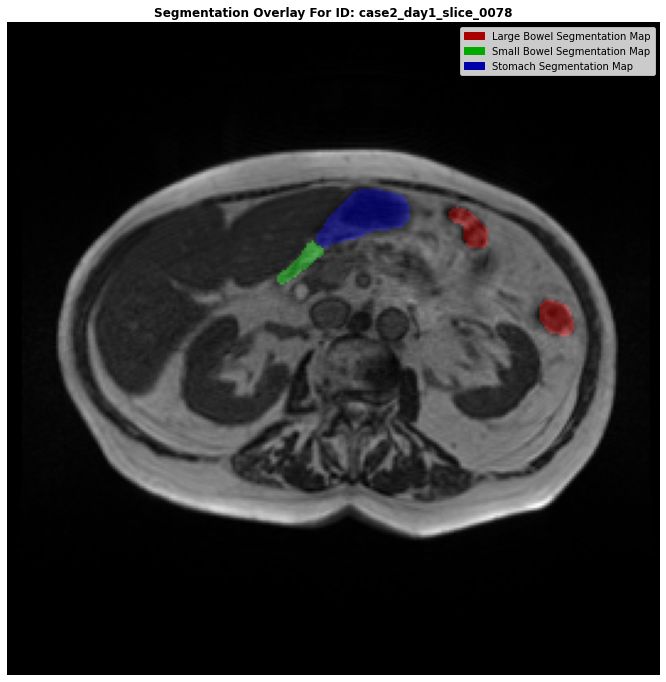



... SINGLE ID EXPLORATION FINISHED ...



... ID (case53_day0_slice_0088) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



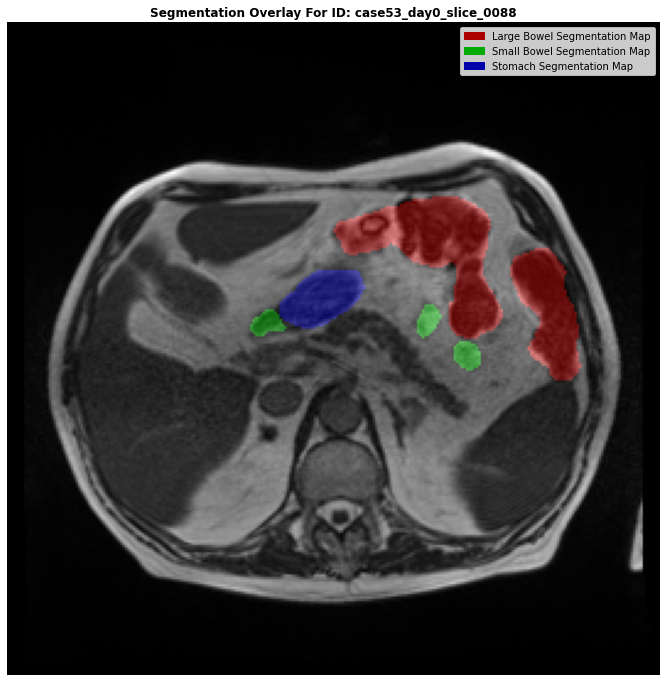



... SINGLE ID EXPLORATION FINISHED ...




In [15]:
# Plot 10 random-ids where all tumor locales are present (max one id per case)
import random

N_TO_PLOT = 10
for _id in train_df[train_df.n_segs==3].groupby("case_id")["id"].first().sample(N_TO_PLOT):
    examine_id(_id)